## 23.1 Fibonacci

The infinite integer sequence 1, 1, 2, 3, 5, 8, 13, 21, ... is known as
the Fibonacci sequence. The first two numbers are 1 and thereafter
each number is the sum of the previous two.
(You can search online for the history and relevance of this sequence,
if you're interested.)

This section uses the problem of computing the *n*-th Fibonacci number,
for *n* ≥ 1, to explain the need for dynamic programming and how it works.
We'll use these tests:

In [1]:
from algoesup import test

fibonacci_tests = [
    # case,     n,  n-th Fibonacci number
    ('n = 1',   1,  1),
    ('n = 2',   2,  1),
    ('n = 6',   6,  8),
    ('n = 10', 10, 55)
]

### 23.1.1 Recursive

To develop a dynamic programming algorithm we must start with a
recursive definition of the problem at hand, which is:

fibonacci(1) = 1\
fibonacci(2) = 1\
fibonacci(*n*) = fibonacci(*n*−1) + fibonacci(*n*−2) for *n* > 2

The recursive algorithm follows the definition directly.

In [2]:
def fibonacci_rec(n: int) -> int:
    """Return the n-th Fibonacci number, computed recursively.

    Preconditions: n > 0
    """
    if n == 1 or n == 2:
        return 1
    else:
        return fibonacci_rec(n - 1) + fibonacci_rec(n - 2)

test(fibonacci_rec, fibonacci_tests)

Testing fibonacci_rec...
Tests finished: 4 passed, 0 failed.


Unfortunately this algorithm quickly gets very slow.

In [3]:
for n in range(20, 25):
    %timeit -r 3 fibonacci_rec(n)

486 μs ± 4.48 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
788 μs ± 2.72 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
1.28 ms ± 648 ns per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
2.07 ms ± 1.19 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
3.35 ms ± 3.99 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Computing the twentieth Fibonacci number should only require a few additions,
done in nanoseconds, and yet it's taking hundreds of microseconds!
The run-time is almost doubling every time *n* increases.
This indicates exponential complexity in the value of *n*.

We can confirm this with a
[recursive definition of the run-time](../13_Divide/13_1_decrease_one.ipynb#13.1.1-Factorial).
Computing the first two Fibonacci numbers takes constant time.
Every other value takes the time to compute the previous two values
and some further constant time for adding them together.

T(1) = Θ(1)\
T(2) = Θ(1)\
T(*n*) = T(*n*−1) + T(*n*−2) + Θ(1) for *n* > 2

Computing fibonacci(*n*–1) involves computing fibonacci(*n*–2),
so the former takes longer to compute than the latter: T(*n*–1) > T(*n*–2).
This means that T(*n*) > 2×T(*n*–2):
the run-time for *n* is more than double that for *n*−2,
as the above run-times confirm: the 24th number takes more than double the time
to compute the 22nd, which in turn takes more than double the time for the 20th.
If a fixed increment of the input (here, by two)
more than doubles the run-time, this means the complexity is exponential.

The exponential run-time is due to the overlapping subproblems.
(A subproblem is a smaller instance of the same problem.)
A diagram shows this best. Here are the recursive calls for *n* = 6,
abbreviating the function name to 'fib' to avoid cluttering the diagram.

<p id="fig-23.1.1"></p>

*[Figure 23.1.1](../33_Figures/Figures_23_1.ipynb#Figure-23.1.1)*

![Image 23_1_recursive.png](23_1_recursive.png)

The nodes for *n* = 3 and *n* = 4&nbsp;have a common child: *n* = 2.
Hence the two problem instances overlap:
they require solving a common smaller instance.
More generally, problem instances *n* and *n*–1 overlap because they
have common subproblem *n*–2. The diagram shows that
the algorithm is repeatedly solving the common subproblems.
For example, the base case *n* = 2 is computed five times!

### 23.1.2 Top-down

A simple way to reduce the run-time is to store the result for each subproblem
in a **cache**. When the solution of a subproblem is computed,
it's put in the cache so that subsequent calls for the same subproblem
simply look up the solution instead of recomputing it.

The cache is a data structure that maps subproblems to solutions and
so any implementation of the [map ADT](../08_Unordered/08_1_map.ipynb#8.1-Maps) will do, e.g. a hash table
where the keys are the subproblems and
the values are the corresponding solutions.
Once a subproblem–solution pair is added to the cache,
it's never removed or modified.
So the cache only has to support two ADT operations:
membership (is a subproblem already in the cache?) and
lookup (what's the solution for this subproblem?).

Adding a cache to the recursive algorithm can be done in a systematic way.
Here's the recursive function again, without repeating the docstring:
```py
def fibonacci(n: int) -> int:
    if n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)
```
Now the version with a cache.
First we check if the subproblem is in the cache. If it isn't,
we follow the recursive algorithm and store the computed solution in the cache.
Finally we return the cached solution, which was already there or
has just been computed.
```py
def fibonacci(n: int, cache: dict) -> int:
    if n not in cache:
        if n == 1 or n == 2:
            cache[n] = 1
        else:
            cache[n] = fibonacci(n - 1, cache) + fibonacci(n - 2, cache)
    return cache[n]
```
This function has a second parameter, so we can't reuse the tests written above.
Moreover, it allows the caller to initially pass any dictionary,
which could lead to wrong results.

A better version hides the cache from the user:
the main function creates an empty cache and
an inner recursive function uses it.
(Remember that inner functions can access the variables of outer functions.)

In [4]:
def fibonacci_td(n: int) -> int:
    def fib(n: int) -> int:
        """Cached version of fibonacci()."""
        if n not in cache:
            if n == 1 or n == 2:
                cache[n] = 1
            else:
                cache[n] = fib(n - 1) + fib(n - 2)
        return cache[n]

    cache = dict()
    return fib(n)

test(fibonacci_td, fibonacci_tests)

Testing fibonacci_td...
Tests finished: 4 passed, 0 failed.


In the expression `fib(n-1) + fib(n-2)`, the call `fib(n-2)`
takes constant time because it just retrieves the value from the cache:
the call `fib(n-1)` already computed `fib(n-2)`.
So the second call to `fib(n-2)` makes no further recursive calls.
The call tree of the inner function for *n* = 6 becomes:

<p id="fig-23.1.2"></p>

*[Figure 23.1.2](../33_Figures/Figures_23_1.ipynb#Figure-23.1.2)*

![Image 23_1_top_down.png](23_1_top_down.png)

The recursive complexity definition becomes

T(0) = Θ(1)\
T(1) = Θ(1)\
T(*n*) = T(*n*−1) + Θ(1)

As explained in [Section&nbsp;13.1.1](../13_Divide/13_1_decrease_one.ipynb#13.1.1-Factorial),
this results in T(*n*) = Θ(*n*). Caching the subproblems' solutions
lowered the complexity from exponential to linear!
Doubling the value of *n* confirms that
the run-times more or less double too.

In [5]:
for n in (8, 16, 32, 64):
    %timeit -r 3 fibonacci_td(n)

1.09 μs ± 0.298 ns per loop (mean ± std. dev. of 3 runs, 1,000,000 loops each)
2.16 μs ± 2.68 ns per loop (mean ± std. dev. of 3 runs, 100,000 loops each)
4.3 μs ± 3.83 ns per loop (mean ± std. dev. of 3 runs, 100,000 loops each)
8.57 μs ± 11.1 ns per loop (mean ± std. dev. of 3 runs, 100,000 loops each)


The technique of caching the solutions as they're recursively computed
is known as **top-down dynamic programming**. It starts
with the given input (represented by the root node of the call tree) and then
recursively solves smaller instances until it reaches a leaf of the call tree,
which is either a base case or an already solved (i.e. cached) subproblem.

<div class="alert alert-info">
<strong>Info:</strong> Top-down dynamic programming is also called recursion with memoisation
(not memorisation).
</div>

### 23.1.3 Bottom-up

Let's look again at the full call tree in Figure 23.1.1: it shows for each
problem node the two children subproblems it depends on.
The leaves are the base cases (*n* = 1 and *n* = 2), which depend on nothing.

We can solve the problem instances bottom-up:
knowing the solutions for the base cases
allows us to compute the solution for their parent (*n* = 3), which in turn
allows us to compute the solution for its parent (*n* = 4) and so on until
we reach the root.

This can be done iteratively, by adding to the cache the solutions to
*n* = 1, 2, 3, ..., in this order.
This ensures that when computing the *n*-th Fibonacci number,
the two previous numbers are already in the cache.

In [6]:
def fibonacci_bu(n: int) -> int:
    # create cache with base cases fibonacci(1) = fibonacci(2) = 1
    cache = {1: 1, 2: 1}
    for number in range(3, n+1):
        cache[number] = cache[number-1] + cache[number-2]
    return cache[n]

test(fibonacci_bu, fibonacci_tests)

Testing fibonacci_bu...
Tests finished: 4 passed, 0 failed.


The complexity is linear because the loop executes *n*−2 additions.
Even though the complexity is the same as for top-down dynamic programming,
this version runs faster, because there are no recursive calls and
no checks for cached solutions (since they are computed in the order needed).

In [7]:
for n in (8, 16, 32, 64):
    %timeit -r 3 fibonacci_bu(n)

529 ns ± 0.281 ns per loop (mean ± std. dev. of 3 runs, 1,000,000 loops each)
1.03 μs ± 7.51 ns per loop (mean ± std. dev. of 3 runs, 1,000,000 loops each)
1.89 μs ± 5.45 ns per loop (mean ± std. dev. of 3 runs, 1,000,000 loops each)
3.67 μs ± 1.67 ns per loop (mean ± std. dev. of 3 runs, 100,000 loops each)


Iteratively filling the cache from the smaller to the larger problem instances,
so that each one is solved using already cached solutions, is known as
**bottom-up dynamic programming**.

### 23.1.4 With arrays

To calculate the *n*-th Fibonacci number, we must solve the problem instances
1, 2, 3, ..., *n*. Since these are natural numbers,
we can use them to index an array of solutions,
instead of hashing them to retrieve solutions from a dictionary.

The array must be initialised with impossible solutions, so that
it's easy to check whether a solution has been cached or not.
Fibonacci numbers are always positive, so the cache can be initialised
with zeroes or with negative numbers. I choose zeroes.

I only have to change two lines of code to replace the dictionary in
the top-down approach with a Python list, used as a static array.

In [8]:
def fibonacci_tda(n: int) -> int:
    def fib(n: int) -> int:
        if cache[n] == 0:   # changed
            if n == 1 or n == 2:
                cache[n] = 1
            else:
                cache[n] = fib(n - 1) + fib(n - 2)
        return cache[n]

    cache = [0] * (n+1)     # changed
    return fib(n)

test(fibonacci_tda, fibonacci_tests)

Testing fibonacci_tda...
Tests finished: 4 passed, 0 failed.


And now the bottom-up approach. I only change the cache creation.

In [9]:
def fibonacci_bua(n: int) -> int:
    cache = [0] * (n+1)
    cache[1] = 1        # first base case
    if n > 1:
        cache[2] = 1    # second base case
    for number in range(3, n+1):
        cache[number] = cache[number-1] + cache[number-2]
    return cache[n]

test(fibonacci_bua, fibonacci_tests)

Testing fibonacci_bua...
Tests finished: 4 passed, 0 failed.


Dynamic programming usually uses arrays, which require less memory
than maps based on hash tables.

Let's compare the run-times of all approaches.
I only double the input four times (instead of the default ten times) because
the recursive version takes too long (exponential time).

Inputs generated by int_value

Input value   fibonacci_rec    fibonacci_td   fibonacci_tda    fibonacci_bu   fibonacci_bua 
          1            51.9           252.7           255.6           140.1           155.7 ns
          2            55.8           254.9           256.4           138.1           159.6 ns
          4           196.0           537.3           492.6           278.0           270.0 ns
          8          1488.4          1099.4           949.0           550.1           448.4 ns
         16         71078.1          2164.6          1774.9          1037.3           728.7 ns

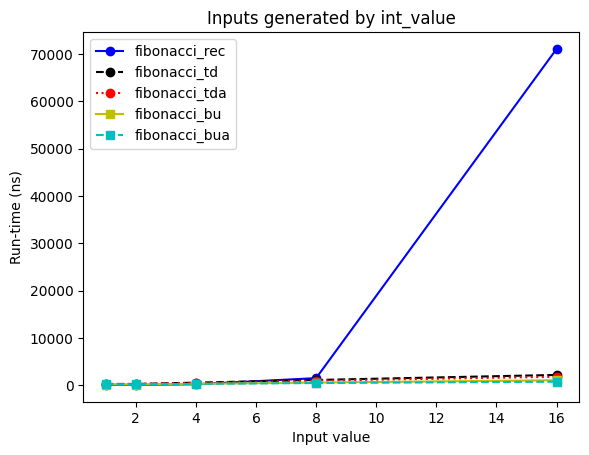

In [10]:
from algoesup import time_functions_int

time_functions_int([
    fibonacci_rec, fibonacci_td, fibonacci_tda, fibonacci_bu, fibonacci_bua
    ], double=4)

As expected, an array-based cache leads to shorter times than a dictionary-based cache.
The recursive version doesn't set up a cache and so it is initially the fastest,
but the space-time tradeoff of the other versions quickly pays off,
as the recursive version gets slower and slower.

### 23.1.5 A graph perspective

An alternative way of understanding dynamic programming is to look at
the dependency graph of the problem instances.
The nodes are the instances to be solved.
If instance A must be solved before instance B, we draw an edge from A to B.
The directed graph is acyclic because an instance can't depend on itself:
that would make it impossible to solve.

Here's the DAG (directed acyclic graph) for *n* = 6.
It's the recursive call tree with repeated nodes merged.

<p id="fig-23.1.3"></p>

*[Figure 23.1.3](../33_Figures/Figures_23_1.ipynb#Figure-23.1.3)*

![Image 23_1_dag.png](23_1_dag.png)

The DAG shows that each instance (except the base cases) depends on
two smaller ones: every node, except for the base cases, has two in-neighbours.

Most nodes also have two out-neighbours, i.e. the solution of
one instance is needed for two further instances.
If there are edges from A to B and from A to C,
this means instances B and C overlap because they have subproblem A in common.
Hence we need dynamic programming, because
recursion without a cache would repeatedly compute the common subproblems.

<div class="alert alert-warning">
<strong>Note:</strong> If the DAG of the problem instances and their dependencies shows that
instances overlap, i.e. there are nodes with a common in-neighbour, then
use dynamic programming.
</div>

Looking at the DAG, we can see that both recursive versions
(with and without cache) follow the edges backwards:
they start with the right-most node (the input instance, here *n* = 6) and
for each node do the two recursive calls corresponding to its in-neighbours.

Bottom-up dynamic programming instead starts with
the left-most nodes (the base cases) and
uses the subproblems solved so far to solve the next subproblem.
It follows the dependency edges to solve increasingly larger subproblems
until it reaches the input value (right-most node).

Dynamic programming caches the solution for a problem instance after solving it.
This means its subproblems have been solved, and thus cached, beforehand.
In other words, a subproblem P is cached after all subproblems that P depends on
were cached. This means the cache is filled in topological order.

<div class="alert alert-warning">
<strong>Note:</strong> Dynamic programming fills the cache (i.e. solves the subproblems) according to
the topological sort of the instance dependency DAG.
</div>

The DAG is just a conceptual device to understand subproblem dependencies and
in which order the subproblems are added to the cache.
As you've seen in this section, dynamic programming algorithms fill the cache
without creating a graph data structure and computing a topological sort.

⟵ [Previous section](23-introduction.ipynb) | [Up](23-introduction.ipynb) | [Next section](23_2_lcs.ipynb) ⟶